In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from pyfermions import *

Test our Python implementation of Selesnick's algorithm from Selesnick, "The Design of Approximate Hilbert Transform
Pairs of Wavelet Bases" (2002).

# Half-delay

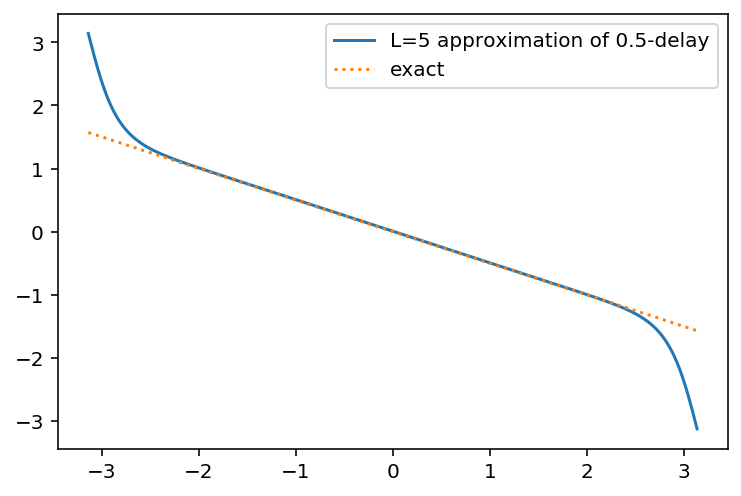

In [2]:
# tau-pass filter at approximation level L
tau = 1 / 2
L = 5
d = signal(allpass(tau, L))

# plot
k = np.arange(-np.pi, np.pi, .01)
D = d.ft(k)
plt.plot(
    k,
    np.angle(np.exp(-1j * L * k) * D[::-1] / D),
    label='L=%d approximation of %s-delay' % (L, tau))
plt.plot(k, -tau * k, ':', label='exact')
plt.legend()
plt.show()

# Selesnick wavelets

## Table II

Example 1A: $N=12, K=4, L=2$

In [3]:
# there are choices in the spectral factorization, and our choices are somewhat different
def swap_and_reverse_pair(h, g):
    h_s = h.scaling_filter
    g_s = g.scaling_filter
    h_rev = orthogonal_wavelet.from_scaling_filter(g_s.reverse())
    g_rev = orthogonal_wavelet.from_scaling_filter(h_s.reverse())
    return h_rev, g_rev


def make_table(K, L, swap_and_reverse=False):
    h, g = selesnick_hwlet(K, L)
    if swap_and_reverse:
        h, g = swap_and_reverse_pair(h, g)
    return pd.DataFrame(
        {
            'h_0(n)': h.scaling_filter.to_pandas(),
            'g_0(n)': g.scaling_filter.to_pandas()
        },
        columns=['h_0(n)', 'g_0(n)'])


make_table(K=4, L=2)

,h_0(n),g_0(n)
0,-0.001785,-0.000357
1,0.013359,-0.000185
2,0.036091,0.032591
3,-0.034722,0.013450
4,0.041525,-0.058467
5,0.560358,0.274643
6,0.774586,0.779566
7,0.227521,0.540974
8,-0.160409,-0.040315
9,-0.061694,-0.133201


Example 2: $N=12,K=3,L=3$

In [4]:
make_table(K=3, L=3, swap_and_reverse=True)

,h_0(n),g_0(n)
-11,-0.015583,-0.002226
-10,-0.049432,-0.042679
-9,0.216754,0.024829
-8,0.745850,0.498278
-7,0.613337,0.799727
-6,-0.015506,0.286786
-5,-0.127050,-0.156428
-4,0.032370,-0.033190
-3,0.019701,0.043428
-2,-0.006191,-0.002205


## Figure 1

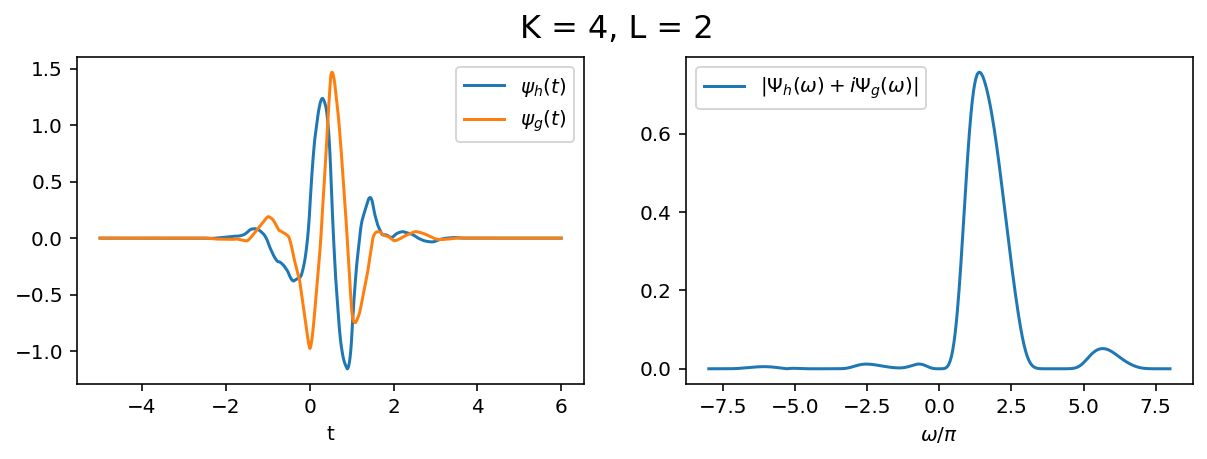

In [5]:
def show(K, L, swap_and_reverse=False, min_phase=False):
    h, g = selesnick_hwlet(K, L, min_phase=min_phase)
    if swap_and_reverse:
        h, g = swap_and_reverse_pair(h, g)

    fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
    fig.suptitle("K = %s, L = %s" % (K, L), size=16)

    # wavelet functions (times -1)
    x_h, psi_h = h.wavelet_function(12)
    x_g, psi_g = g.wavelet_function(12)
    ax[0].plot(x_h, -psi_h, label=r'$\psi_h(t)$')
    ax[0].plot(x_g, -psi_g, label=r'$\psi_g(t)$')
    ax[0].set_xlabel('t')
    ax[0].legend()

    #
    omega_h, Psi_h = ctft(x_h, psi_h, omega_max=8 * np.pi)
    omega_g, Psi_g = ctft(x_g, psi_g, omega_max=8 * np.pi)
    assert np.allclose(omega_h, omega_g)
    ax[1].plot(
        omega_h / np.pi,
        np.abs(Psi_h + 1j * Psi_g),
        label=r'$|\Psi_h(\omega) + i \Psi_g(\omega)|$')
    ax[1].set_xlabel(r'$\omega/\pi$')
    ax[1].legend()


show(4, 2)

## Figure 2

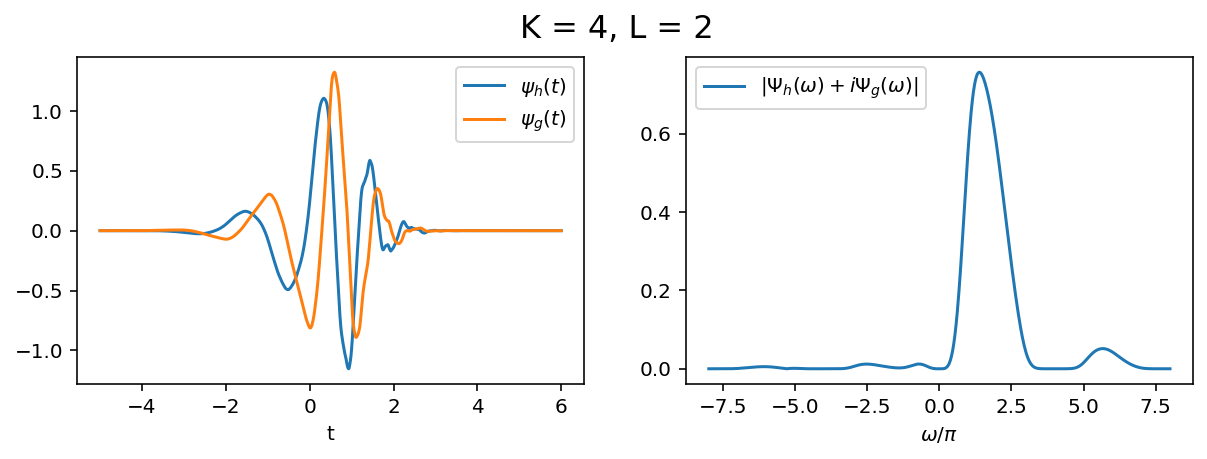

In [6]:
show(4, 2, min_phase=True)

## Figure 3

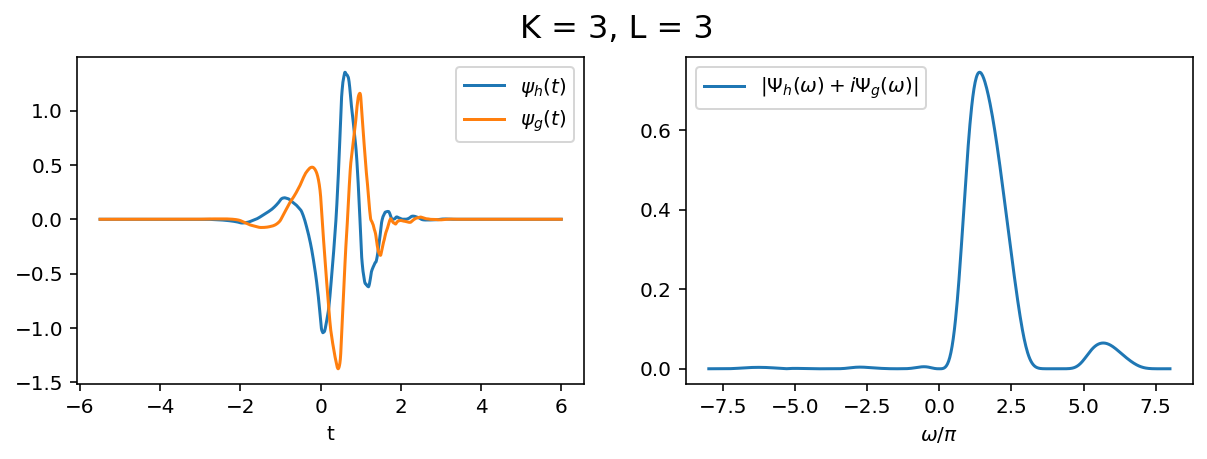

In [7]:
show(3, 3, swap_and_reverse=True)

# Error Analysis

Plot the $L^\infty$-error between $\Psi_g(\omega)$ and $-i\mathrm{sign}(\omega)\psi_h(\omega)$, as well as between $G_s(k)$ and $e^{-ik/2} H_s(k)$, for various values of $K$ and $L$:

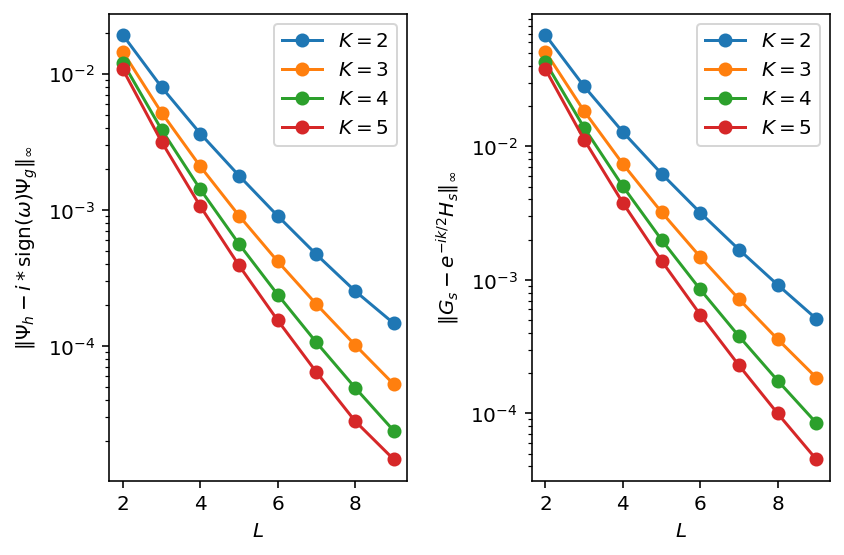

In [8]:
K_values = np.arange(2, 6)
L_values = np.arange(2, 10)
NUM_LEVELS = 16

fig, ax = plt.subplots(ncols=2)
for K in K_values:
    diff_Psi = []
    diff_S = []
    for L in L_values:
        h, g = selesnick_hwlet(K, L)

        # wavelet functions
        x_h, psi_h = h.wavelet_function(NUM_LEVELS)
        x_g, psi_g = g.wavelet_function(NUM_LEVELS)
        omega, Psi_h = ctft(x_h, psi_h, omega_max=8 * np.pi)
        omega_g, Psi_g = ctft(x_g, psi_g, omega_max=8 * np.pi)
        assert np.allclose(omega, omega_g)
        diff_Psi.append(np.max(np.abs(Psi_h - 1j * np.sign(omega) * Psi_g)))

        # scaling filters
        h_s, g_s = h.scaling_filter, g.scaling_filter
        k = np.arange(-np.pi, np.pi, .01)
        H_s, G_s = h_s.ft(k), g_s.ft(k)
        diff_S.append(np.max(np.abs(G_s - np.exp(-1j * k / 2) * H_s)))

    # plot
    ax[0].set_xlabel('$L$')
    ax[0].set_ylabel(
        r'$\Vert \Psi_h - i*\mathrm{sign}(\omega) \Psi_g \Vert_\infty$')
    ax[0].semilogy(L_values, diff_Psi, '-o', label='$K = %d$' % K)
    ax[0].legend()

    ax[1].set_xlabel('$L$')
    ax[1].set_ylabel(r'$\Vert G_s - e^{-i k/2} H_s \Vert_\infty$')
    ax[1].semilogy(L_values, diff_S, '-o', label='$K = %d$' % K)
    ax[1].legend()
    fig.tight_layout()

plt.show()

PS: If the wavelet error flattens then `NUM_LEVELS` should be increased.